In [1]:
from PIL import Image
import numpy as np 
from PIL import ImageDraw
from skimage.util.shape import view_as_windows
from skimage.transform import pyramid_gaussian
from utils.params import *
import math
from models._12_net import detect_12Net, calib_12Net
from models._24_net import detect_24Net, calib_24Net
from models._48_net import detect_48Net, calib_48Net
import tensorflow as tf
from utils.cnn_utils import *
from utils.utilities import *
from utils import save
import sys
import pickle

In [2]:
def final_eval(boxes):
    boxes = boxes.astype(np.float32)
    xmin = boxes[:,0]
    ymin = boxes[:,1]
    xmax = boxes[:,2]
    ymax = boxes[:,3]
    
    area = (xmax-xmin+1) * (ymax-ymin+1)
    idxs = np.argsort(area)
    
    chosen_idxs = []
    while(len(idxs)>0):
        end = len(idxs) - 1
        current = idxs[end]
        chosen_idxs.append(current)
        
        xminx = np.maximum(xmin[current], xmin[idxs[:end]])
        yminy = np.maximum(ymin[current], ymin[idxs[:end]])
        xmaxx = np.minimum(xmax[current], xmax[idxs[:end]])
        ymaxy = np.minimum(ymax[current], ymax[idxs[:end]])
        
        bound_width = np.maximum(0, xmaxx - xminx + 1)
        bound_height = np.maximum(0, ymaxy - yminy + 1)
        
        overlap = (bound_width * bound_height) / area[idxs[:end]]
        delete_idxs = np.concatenate(([end], np.where(overlap>.9)[0]))
        idxs = np.delete(idxs, delete_idxs)
    return boxes[chosen_idxs].astype(np.int32)

### Setup CascadeCNNs

In [3]:
g = tf.Graph()
with g.as_default():
    input_det_12 = tf.placeholder(tf.float32, [None, None, None, 3])
    target_det_12 = tf.placeholder(tf.float32, [None,1])
    det_net_12 = detect_12Net(input_det_12, target_det_12, keep_prob=1.0, learning_rate=5e-3)

with g.as_default():
    input_cal_12 = tf.placeholder(tf.float32, [None, None, None, 3])
    target_cal_12 = tf.placeholder(tf.float32, [None,45])
    cal_net_12 = calib_12Net(input_cal_12, target_cal_12, keep_prob=1.0)
    
with g.as_default():
    input_det_24 = tf.placeholder(tf.float32, [None, None, None, 3])
    target_det_24 = tf.placeholder(tf.float32, [None,1])
    det_net_24 = detect_24Net(input_det_24, target_det_24, keep_prob=1.0, lr=5e-3)
    
with g.as_default():
    input_cal_24 = tf.placeholder(tf.float32, [None, None, None, 3])
    target_cal_24 = tf.placeholder(tf.float32, [None,45])
    cal_net_24 = calib_24Net(input_cal_24, target_cal_24, keep_prob=1.0)

with open(p_model_dir + 'det_48/mean_var/Adam_48Net_1.txt', 'rb') as f:
    mean_var_list_det48 = pickle.load(f)
    f.close()
    
with g.as_default():
    input_det_48 = tf.placeholder(tf.float32, [None, None, None, 3])
    target_det_48 = tf.placeholder(tf.float32, [None, 1])
    det_net_48 = detect_48Net(input_det_48, target_det_48, keep_prob=1.0, lr=1e-3, bias_init=0.0, reg=0.0, Train=False, 
                              BN_list1 = [mean_var_list_det48[0], mean_var_list_det48[1]], BN_list2 = [mean_var_list_det48[2], 
                                                                                                       mean_var_list_det48[3]])
with open(p_model_dir + 'calib_48/mean_var/Adam_48Net_1.txt', 'rb') as f:
    mean_var_list_cal48 = pickle.load(f)
    f.close()

with g.as_default():
    input_cal_48 = tf.placeholder(tf.float32, [None, 48, 48, 3])
    target_cal_48 = tf.placeholder(tf.float32, [None, 45])
    cal_net_48 = calib_48Net(input_cal_48, target_cal_48, keep_prob=1.0, lr=1e-3, bias_init=0.0, reg=0.0, Train=False, 
                              BN_list1 = [mean_var_list_cal48[0], mean_var_list_cal48[1]], BN_list2 = [mean_var_list_cal48[2], 
                                                                                                       mean_var_list_cal48[3]])
    
sess = tf.InteractiveSession(config=tf.ConfigProto(
  allow_soft_placement=True, log_device_placement=True), graph=g)

restorer_12 = tf.train.Saver([v for v in tf.global_variables() if "12det_" in v.name])
restorer_12.restore(sess, p_model_dir + "det_12/max/12_net_Adam_3.ckpt")

restorer_12 = tf.train.Saver([v for v in tf.global_variables() if "12cal_" in v.name])
restorer_12.restore(sess, p_model_dir + "calib_12/max/Calib_12_Adam_1.ckpt")

restorer_24 = tf.train.Saver([v for v in tf.global_variables() if "24det_" in v.name])
restorer_24.restore(sess, p_model_dir + "det_24/max/_Net24_Adam_2.ckpt")

restorer_24 = tf.train.Saver([v for v in tf.global_variables() if "24cal_" in v.name])
restorer_24.restore(sess, p_model_dir + "calib_24/max/24_net_Adam_1.ckpt")

restorer_48 = tf.train.Saver([v for v in tf.global_variables() if "48det_" in v.name])
restorer_48.restore(sess, p_model_dir + 'det_48/max/' + 'Adam_48Net_1.ckpt')

restorer_48 = tf.train.Saver([v for v in tf.global_variables() if "48cal_" in v.name])
restorer_48.restore(sess, p_model_dir + 'calib_48/max/' + 'Adam_48Net_1.ckpt')

INFO:tensorflow:Restoring parameters from saver/det_12/max/12_net_Adam_3.ckpt
INFO:tensorflow:Restoring parameters from saver/calib_12/max/Calib_12_Adam_1.ckpt
INFO:tensorflow:Restoring parameters from saver/det_24/max/_Net24_Adam_2.ckpt
INFO:tensorflow:Restoring parameters from saver/calib_24/max/24_net_Adam_1.ckpt
INFO:tensorflow:Restoring parameters from saver/det_48/max/Adam_48Net_1.ckpt
INFO:tensorflow:Restoring parameters from saver/calib_48/max/Adam_48Net_1.ckpt


In [34]:
test_dir_ppl = 'Test_source/test_samples/'
img_path = 'Test_source/test_samples/58746068_p0.jpg'
test_img = img_scalar(img_path)
sxy_dict = save.loader('sxy_dict.txt')

Loaded from D:\programing project\python project\trying stuffpickle/


In [35]:
# return xmin, ymin, xmax, ymax, confidence score, img_crop obj, scale
detec_wins = detection_windows(test_img, p_net_12, det_net_12, input_det_12, thres=0.001)

tmp_12 = np.zeros((len(detec_wins), p_net_12, p_net_12, 3))
for id_, window in enumerate(detec_wins):
    tmp_12[id_,:] = img2array(window[5], 12)
    
calibrate_matrix = cal_net_12.prediction.eval(feed_dict={input_cal_12:tmp_12})
tmp_12_adjust = np.zeros((len(detec_wins), 5))
for id_, calibration in enumerate(calibrate_matrix):
    tmp_12_adjust[id_:] = det_window_calibration(detec_wins[id_], sxy_dict, calibration)

NMS_12_adjusted = NMS_by_scale(tmp_12_adjust, 0.4)


_24Net_filters = []
_24Net_Det_score = np.zeros((len(NMS_12_adjusted)))
cnt = 0
cal_cnt = 0
final_cnt = 0

img = img_scalar(img_path)
for idx_, select_ in enumerate(NMS_12_adjusted):
    sys.stdout.write('\rProgress: ' + str(idx_+1) + '/' + str(NMS_12_adjusted.shape[0]))
    
    # Select the location of selected img
    sample = select_[:4]
    
    # crop the image according to the selected location
    # img = img_scalar(img_path)
    sample_crop = img.crop(sample)
    # img.close()
    
    # Go through the first 24-CNN for classification
    resized = img2array(sample_crop, 24).reshape(1,24,24,3)
    det_wins_pred = det_net_24.prediction_flatten.eval(feed_dict={input_det_24:resized})
    _24Net_Det_score[idx_] = det_wins_pred
    
det24_idx = np.where(_24Net_Det_score>1e-4)[0]
chosen_24 = NMS_12_adjusted[det24_idx]
det24_wins = [0 for _ in range(len(det24_idx))]

# filter out important data for next net
tmp_24 = np.zeros((len(chosen_24), p_net_24, p_net_24, 3))
for id_, loc in enumerate(chosen_24):
    # img = img_scalar(img_path)
    sample_crop = img.crop(loc[:4])
    # img.close()

    tmp_24[id_,:] = img2array(sample_crop, p_net_24)

# Go through the second 24-CNN for location calibration
calibrate_matrix = cal_net_24.prediction.eval(feed_dict={input_cal_24:tmp_24})

# Adjusted the images according to the 24-CNN calibration net
tmp_24_adjust = np.zeros((len(chosen_24), 5))
for id_, calibration in enumerate(calibrate_matrix):
    tmp_24_adjust[id_:] = det_window_calibration_24after(chosen_24[id_], sxy_dict, calibration)
    
NMS_24_adjusted = NMS_by_scale(tmp_24_adjust, 0.5) 

Progress: 516/516

In [36]:

_48Net_Det_score = np.zeros((len(NMS_24_adjusted)))

for idx_, select_ in enumerate(NMS_24_adjusted):
    sys.stdout.write('\rProgress: ' + str(idx_+1) + '/' + str(NMS_24_adjusted.shape[0]))

    # Select the location of selected img
    sample = select_[:4]
    sample_crop = img.crop(sample)

    resized = img2array(sample_crop, 48).reshape(1,48,48,3)
    det_wins_pred = det_net_48.h_fc_conv2_flat.eval(feed_dict={input_det_48:resized})
    _48Net_Det_score[idx_] = det_wins_pred

det48_idx = np.where(_48Net_Det_score>5e-1)[0]
chosen_48 = NMS_24_adjusted[det48_idx]
det48_wins = [0 for _ in range(len(det48_idx))]

# filter out important data for next net
tmp_48 = np.zeros((len(chosen_48), p_net_48, p_net_48, 3))

for id_, loc in enumerate(chosen_48):
    # img = img_scalar(img_path)
    sample_crop = img.crop(loc[:4])
    # img.close()
    tmp_48[id_,:] = img2array(sample_crop, p_net_48)

# Go through the second 48-CNN for location calibration
calibrate_matrix = cal_net_48.prediction.eval(feed_dict={input_cal_48:tmp_48})

# Adjusted the images according to the 24-CNN calibration net
tmp_48_adjust = np.zeros((len(chosen_48), 5))
for id_, calibration in enumerate(calibrate_matrix):
    tmp_48_adjust[id_:] = det_window_calibration_24after(chosen_48[id_], sxy_dict, calibration)
try:
    NMS_48_adjusted = NMS(tmp_48_adjust, 0.5)
    NMS_48_adjusted = final_eval(NMS_48_adjusted)
    print('\nSuggested_Windows: {}'.format(NMS_48_adjusted.shape[0]))
except AttributeError:
    print('\nNo Face Found')

img.close()

Progress: 50/50
Suggested_Windows: 1


In [37]:
imgs = img_scalar(img_path)
for loc in NMS_48_adjusted:
    ImageDraw.Draw(imgs).rectangle(list(loc[:4]), outline='red')

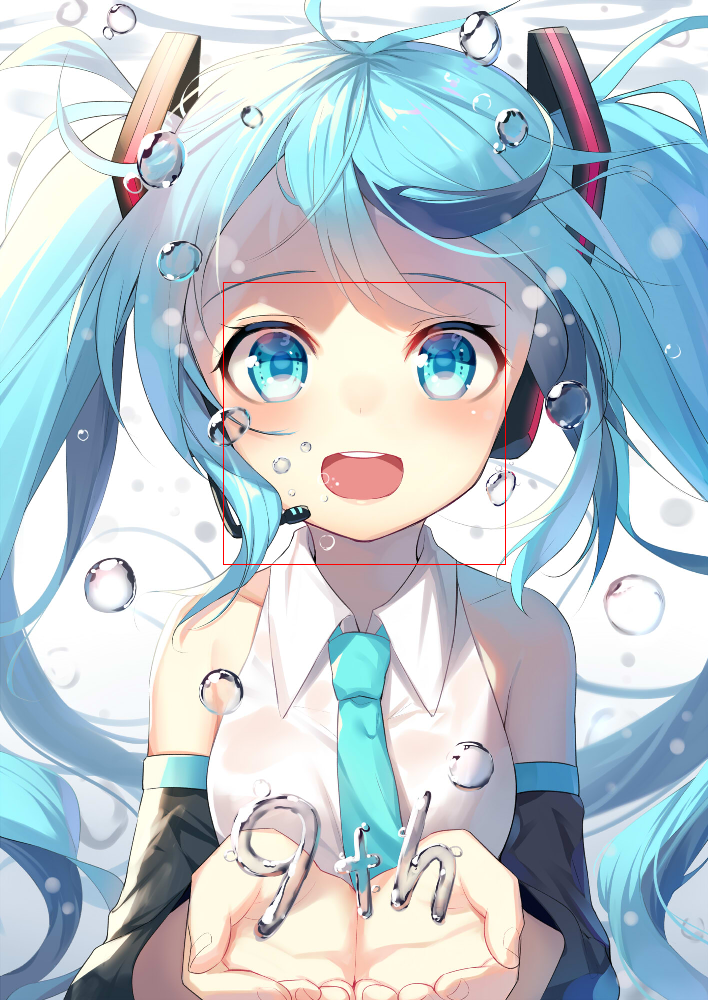

In [38]:
imgs

In [25]:
np.asarray(imgs).shape

(1000, 708, 3)